**This notebook looks at all the word list we have and find out how much they overlap with the 2M-org dataset.**

In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/le3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
%matplotlib inline
from glob import glob
import pandas as pd
from nltk import word_tokenize
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import unicodedata
import re

In [19]:
import sys
sys.path.append('..')

In [20]:
_pattern_capitalized = re.compile('^[A-Z\.\,]+$')

def normalizeToken(tok):
    tok = unicodedata.normalize('NFC', tok)
    if _pattern_capitalized.match(tok):
        return tok
    else:
        return tok.lower()

# Reading word lists and training data

In [79]:
paths = glob('../dicts/*.txt')

In [80]:
%%time
token_wl_info = []
for path in paths:
    with open(path) as f:
        for line in f:
            tokens = line.strip().split()
            for tok in tokens:
                token_wl_info.append({
                    'token': normalizeToken(tok), 'word_list': path
                })

CPU times: user 612 ms, sys: 381 ms, total: 993 ms
Wall time: 1.29 s


In [81]:
token_wl = pd.DataFrame(token_wl_info)

In [82]:
token_wl['lang'] = token_wl.word_list.str.extract(r'\.(\w{2,})\.txt$').fillna('en')

In [83]:
train_2m = pd.read_csv('../output/dataset-2M-noisy.train.csv')

In [84]:
token_train_info = [{'token': normalizeToken(t), 'input': row['input'], 'label': row['label']} 
                  for _, row in tqdm(train_2m.iterrows(), total=len(train_2m), position=0)
                  for t in row['input'].split()]

100%|██████████| 1053212/1053212 [03:37<00:00, 4853.16it/s]


In [85]:
token_train_df = pd.DataFrame(token_train_info)

In [86]:
token_train_df.sample(3)

,token,input,label
623813,universität,4. Physikalisches Institut der Universität,SPE
1268727,el,Centro de Investigación en el Ecosistemas de ...,SPE
1590880,kurzzeitspektroskopie,Max-Born-Institut für Nichtlinean Optik und K...,SPE


# Computing overlap

In [87]:
token_found_in_train_2m = set(token_train_df.token)

In [88]:
token_wl['found'] = token_wl.token.apply(token_found_in_train_2m.__contains__)

In [89]:
def stats(df, drop_duplicates=False):
    if drop_duplicates:
        df = df.drop_duplicates('token')
    found = sum(df['found'].astype(int))
    return pd.Series({
        'found': found,
        'total': len(df),
        'found_pct': 100.0*found/len(df)
    })

## Overlap by language

In [90]:
unique_token_by_language_stats = token_wl.groupby('lang').apply(stats, drop_duplicates=True)
unique_token_by_language_stats

,found,total,found_pct
lang,,,
ca,1313.0,5934.0,22.126727
da,2187.0,6812.0,32.105109
de,2086.0,6524.0,31.974249
el,881.0,6475.0,13.606178
en,38714.0,115785.0,33.436110
es,1833.0,5889.0,31.125828
fi,1764.0,6891.0,25.598607
fr,1702.0,5634.0,30.209443
hu,1827.0,6722.0,27.179411


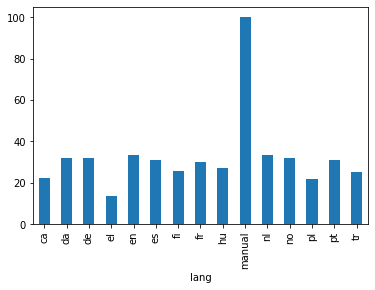

In [91]:
_ = unique_token_by_language_stats.found_pct.plot.bar()

## Overlap by word list

In [92]:
token_by_word_list_stats = token_wl.groupby('word_list').apply(stats)
token_by_word_list_stats

,found,total,found_pct
word_list,,,
../dicts/acronym_whitelist.txt,75306.0,90946.0,82.802982
../dicts/allLocDict.txt,57130.0,124403.0,45.923330
../dicts/blackListDict.txt,86.0,88.0,97.727273
../dicts/commonSubjectsDict.ca.txt,14.0,21.0,66.666667
../dicts/commonSubjectsDict.da.txt,10.0,21.0,47.619048
...,...,...,...
../dicts/wordEndingsDict.no.txt,5.0,18.0,27.777778
../dicts/wordEndingsDict.pl.txt,3.0,17.0,17.647059
../dicts/wordEndingsDict.pt.txt,2.0,18.0,11.111111


In [93]:
unique_token_by_word_list_stats = token_wl.groupby('word_list').apply(stats, drop_duplicates=True)
unique_token_by_word_list_stats

,found,total,found_pct
word_list,,,
../dicts/acronym_whitelist.txt,19747.0,32861.0,60.092511
../dicts/allLocDict.txt,13115.0,64723.0,20.263276
../dicts/blackListDict.txt,25.0,27.0,92.592593
../dicts/commonSubjectsDict.ca.txt,14.0,21.0,66.666667
../dicts/commonSubjectsDict.da.txt,10.0,21.0,47.619048
...,...,...,...
../dicts/wordEndingsDict.no.txt,5.0,18.0,27.777778
../dicts/wordEndingsDict.pl.txt,3.0,17.0,17.647059
../dicts/wordEndingsDict.pt.txt,2.0,18.0,11.111111


## Eyeballing

In [94]:
token_wl.sample(10)

,token,word_list,lang,found
342046,MOE,../dicts/acronym_whitelist.txt,en,True
372822,USDA,../dicts/acronym_whitelist.txt,en,True
236165,hematologia,../dicts/subjectsDict.pt.txt,pt,True
282941,ciència,../dicts/subjectsDict.ca.txt,ca,True
317120,HDQ,../dicts/acronym_whitelist.txt,en,False
297444,CISCOMAR,../dicts/acronym_whitelist.txt,en,False
131247,westhill,../dicts/allLocDict.txt,en,True
286959,AIST,../dicts/acronym_whitelist.txt,en,True
83883,vasculaire,../dicts/subjectsDict-new.fr.txt,fr,True
259820,otorhinolaryngol-head,../dicts/subjectsDict-new.pl.txt,pl,True


In [95]:
novel_found_tokens_shuffled = (token_wl[token_wl.found & (token_wl.lang != 'en')]
                               .drop_duplicates().sample(frac=1., random_state=1323))

In [96]:
novel_found_tokens_shuffled.iloc[:20]

,token,word_list,lang,found
387028,labors,../dicts/typesDict.de.txt,de,True
32915,obstrtrics,../dicts/subjectsDict-new.de.txt,de,True
922,therapie,../dicts/subjectsDict.nl.txt,nl,True
266309,ciências,../dicts/companyNames.pt.txt,pt,True
235674,adolescente,../dicts/subjectsDict.pt.txt,pt,True
85592,ginecologia,../dicts/subjectsDict-new.fr.txt,fr,True
24179,niño,../dicts/subjectModifiersDict.es.txt,es,True
60117,ofdermatovenereology,../dicts/subjectsDict-new.da.txt,da,True
488,público,../dicts/subjectModifiersDict.pt.txt,pt,True
56387,avl,../dicts/subjectsDict-new.da.txt,da,True


In [97]:
novel_found_tokens_shuffled.iloc[20:40]

,token,word_list,lang,found
56070,benedict,../dicts/subjectsDict-new.da.txt,da,True
272681,preventieve,../dicts/subjectsDict-new.nl.txt,nl,True
26374,industriel,../dicts/subjectsDict.fr.txt,fr,True
27630,sociologie,../dicts/subjectsDict.fr.txt,fr,True
59137,marine,../dicts/subjectsDict-new.da.txt,da,True
239306,endokrin,../dicts/subjectsDict.da.txt,da,True
64205,chimistry,../dicts/subjectsDict-new.hu.txt,hu,True
255541,adol,../dicts/subjectsDict-new.pl.txt,pl,True
60342,onkologisk,../dicts/subjectsDict-new.da.txt,da,True
35745,okologie,../dicts/subjectsDict-new.de.txt,de,True


In [98]:
novel_found_tokens_shuffled.iloc[40:60]

,token,word_list,lang,found
30532,engineering-wb3,../dicts/subjectsDict-new.de.txt,de,True
58701,industriali,../dicts/subjectsDict-new.da.txt,da,True
89188,pratiques,../dicts/subjectsDict-new.fr.txt,fr,True
891,cell,../dicts/subjectsDict.nl.txt,nl,True
269940,nb30,../dicts/subjectsDict-new.nl.txt,nl,True
29075,genet,../dicts/subjectsDict-new.de.txt,de,True
60061,ofanalytical,../dicts/subjectsDict-new.da.txt,da,True
266932,cellular,../dicts/subjectsDict-new.nl.txt,nl,True
385127,központ,../dicts/companyNames.hu.txt,hu,True
60656,paediat,../dicts/subjectsDict-new.da.txt,da,True


Apparently, the majority of newly matched tokens are genuinely from other languages.

# Look for org strings that match

In [99]:
tokens_in_en_word_lists = set(token_wl[token_wl.lang.isin(['en', 'manual'])].token)
tokens_in_other_word_lists = set(token_wl[~token_wl.lang.isin(['en', 'manual'])].token)
tokens_in_word_lists = set(token_wl.token)

In [100]:
token_train_df['found'] = token_train_df.token.apply(tokens_in_word_lists.__contains__)
token_train_df['found_en'] = token_train_df.token.apply(tokens_in_en_word_lists.__contains__)
token_train_df['found_others'] = token_train_df.token.apply(tokens_in_other_word_lists.__contains__)
token_train_df['found_novel'] = token_train_df.token.apply(lambda t: t in tokens_in_other_word_lists and 
                                                                     t not in tokens_in_en_word_lists)

In [101]:
novel_token_shuffled = token_train_df[token_train_df.found_novel].sample(frac=1., random_state=9523)

In [102]:
novel_token_shuffled.iloc[:20]

,token,input,label,found,found_en,found_others,found_novel
2619180,ing.,Inst. Invest. en Ing. Genet. y Biol.,SPE,True,False,True,True
313110,botânica,Dep. Botânica UFSCAR,SPE,True,False,True,True
2106615,+,R + V Lebensversicherung AG,SPE,True,False,True,True
299116,technique,de la Recherche Scientifique et Technique Outr...,SPE,True,False,True,True
1405856,komputer,Sekolah Tinggi Manajemen Informatika dan Kompu...,SPE,True,False,True,True
2597819,atomique,Commsrt. l'Energie Atomique,SPE,True,False,True,True
4431942,O,US Geol Surv Earth Rsrc O S,SPE,True,False,True,True
2927483,arzneimittelforschung,Arzneimittelforschung BASF Pharma,SPE,True,False,True,True
575796,für,Institut der Anthropologie und Humangenetik fu...,SPE,True,False,True,True
2097621,E,Lstituto Internazionale di Genetica E Biofisca,SPE,True,False,True,True


In [103]:
novel_token_shuffled.iloc[20:40]

,token,input,label,found,found_en,found_others,found_novel
3097138,eng.,MJ Coll. of Eng. and Technology,SPE,True,False,True,True
3872353,universitaire,Centre Hospitlaier Universitaire Vaudois et Un...,SPE,True,False,True,True
4025420,universitaire,"Laboratoire de Bactériologie, Centre Hospital...",SPE,True,False,True,True
1617792,ministério,Ministério da Saude,SPE,True,False,True,True
3401780,S,S Illinois University atCarbondale,SPE,True,False,True,True
548882,universitario,Hospital Universitario Germans Trías i Pujol,SPE,True,False,True,True
2374490,dice,Dice GmbH,SPE,True,False,True,True
975314,physiol.,Genomique Physiol. de la Lactation,SPE,True,False,True,True
506963,B.,Max-Delbruck-Ctr. Molec. Med. B.,SPE,True,False,True,True
2041640,S,K A S Gentofte Hosp,SPE,True,False,True,True


In [104]:
novel_token_shuffled.iloc[40:60]

,token,input,label,found,found_en,found_others,found_novel
339906,orthopädische,Aus der Chirurgischen Universitätsklinik Erla...,SPE,True,False,True,True
3599168,vrije,Inst for Environmental Studies Vrije Univ. Ams...,SPE,True,False,True,True
1177175,inc,Abbott Inc,SPE,True,False,True,True
1852618,alimentación,Centro de Investigación en Alimentación y De...,SPE,True,False,True,True
2237586,behinderung,Forschungsinstitut Technologie und Behinderung...,SPE,True,False,True,True
2502214,algebry,Katedra algebry a geometrie,SPE,True,False,True,True
1034979,avanzados,Instituto Mediterráneo de Estudios Avanzados (...,SPE,True,False,True,True
4434000,S,The N S Kline Institute for Psychiatric Research,SPE,True,False,True,True
815360,literatur,Instit Sprak and Literatur U Tromso,SPE,True,False,True,True
2100201,mechatronik,Fraunhofer-Institut für Entwurfstechnik Mechat...,SPE,True,False,True,True


## Search for org strings that contain a novel match

In [105]:
%%time
input_train_overlap = token_train_df.groupby('input').agg(
    {'found': any, 'found_en': any, 'found_others': any, 'found_novel': any, 'label': set})
input_train_overlap.sample(10)

CPU times: user 1min 2s, sys: 743 ms, total: 1min 3s
Wall time: 1min 3s


,found,found_en,found_others,found_novel,label
input,,,,,
UMR 1273 Métafort,True,True,False,False,{SPE}
V.I. Lenin Moscow State Institute of Pedagogics,True,True,True,False,{SPE}
Tamir Nadu Agric Univ,True,True,True,True,{SPE}
TeraXion Inc.,True,True,False,False,{SPE}
Institut de Recherchesur la Catalyse,True,True,True,True,{SPE}
Roche Products Limited,True,True,True,False,{SPE}
University ofMichigan Health System,True,True,True,False,{SPE}
Ospedale Bambina Gesu',True,True,False,False,{SPE}
Eiken Chemical Company Ltd.,True,True,True,False,{SPE}


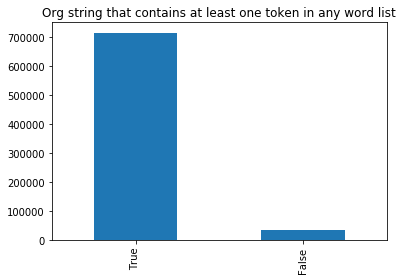

In [106]:
input_train_overlap.found.value_counts().plot.bar()
plt.title("Org string that contains at least one token in any word list")
None

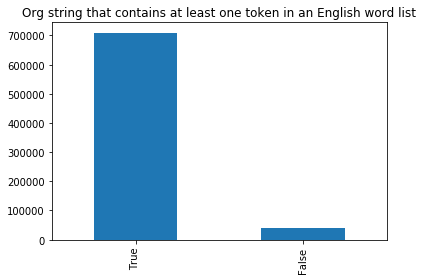

In [107]:
_ = input_train_overlap.found_en.value_counts().plot.bar()
plt.title("Org string that contains at least one token in an English word list")
None

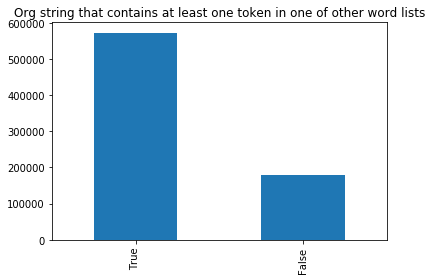

In [108]:
_ = input_train_overlap.found_others.value_counts().plot.bar()
plt.title("Org string that contains at least one token in one of other word lists")
None

100%|██████████| 750840/750840 [00:18<00:00, 40723.40it/s]


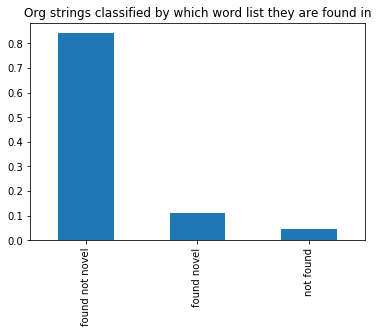

In [120]:
def classify_org_string(row):
    if row['found_novel']:
        return 'found novel'
    elif row['found']:
        return 'found not novel'
    else:
        return 'not found'
        
input_train_overlap['type'] = input_train_overlap.progress_apply(classify_org_string, axis=1)
(input_train_overlap['type'].value_counts() / len(input_train_overlap)).plot.bar()
plt.title("Org strings classified by which word list they are found in")
None

In [110]:
input_train_overlap_novel = input_train_overlap[input_train_overlap.found_novel]
len(input_train_overlap_novel)

84716

In [111]:
len(input_train_overlap_novel) / len(train_2m.drop_duplicates())

0.10802939068648829

In [112]:
input_train_overlap_novel_shuffled = input_train_overlap_novel.sample(frac=1., random_state=89523)

In [113]:
input_train_overlap_novel_shuffled.iloc[:20]

,found,found_en,found_others,found_novel,label,type
input,,,,,,
CPB Nether. Bureau Eco. Pol. Anal.,True,True,True,True,{SPE},found novel
Xtalpi Inc,True,False,True,True,{SPE},found novel
Universit é Pierre et Marie Curie Paris VI,True,True,True,True,{SPE},found novel
Laboratoire de Génie Civil et géoEnvironnement (LGCgE),True,True,True,True,{SPE},found novel
Hôpital Cardiologique de Haut Lévêque,True,True,True,True,{SPE},found novel
Depto. de Quím. Orgán.,True,True,True,True,"{SPE, GEN}",found novel
Hospital Universitario de Malaga Virgen de la Victoria,True,True,True,True,{SPE},found novel
GSF-Forschungszentrum für Umwelt,True,False,True,True,{SPE},found novel
Ctr. d'Etude Spatiale des Rayonnem.,True,True,True,True,{SPE},found novel


In [114]:
input_train_overlap_novel_shuffled.iloc[20:40]

,found,found_en,found_others,found_novel,label,type
input,,,,,,
Centre Jeunesse de Montreal,True,True,True,True,{SPE},found novel
Dr. Ram Manohar Lohia Avadh Univ.,True,True,True,True,{SPE},found novel
Unidad Integrada EEA INTA Balcarce,True,True,True,True,{SPE},found novel
Société Algérienne de l&apos;Electricité et du Gaz,True,True,True,True,{SPE},found novel
Anokhin Inst. Norm. Phys.,True,True,True,True,{SPE},found novel
Investigaciones en Biociencias Agrícolas y Ambientales (INBA),True,True,True,True,{SPE},found novel
Vorstand des Pathol. Instituts der Universität Freiburg,True,True,True,True,{SPE},found novel
Institut Uni versitaire de Medecine Sociale et Preventive,True,True,True,True,{SPE},found novel
Institut für Physiologische Chemie der Philipps-Universität D-3550 Marburg/Lahn,True,True,True,True,{SPE},found novel


In [115]:
input_train_overlap_novel_shuffled.iloc[40:60]

,found,found_en,found_others,found_novel,label,type
input,,,,,,
Laboratoire des Nanotechnologies et Nanosystèmes,True,True,True,True,{SPE},found novel
Centre de Recherches du Service de Santé des Armées Emile Fardé,True,True,True,True,{SPE},found novel
Fraunhofer-Institut für Umweltchemie und Ökotoxikologie Grafschaft,True,True,True,True,{SPE},found novel
Lab. Sci. Cognitives P.,True,True,True,True,{SPE},found novel
Stora Enso Digital Solutions N.V,True,True,True,True,{SPE},found novel
Lekarska Fakulta,True,False,True,True,{SPE},found novel
c o U S National Museum NHB 168,True,True,True,True,{SPE},found novel
Frauenklinik Altona mit Gynäkologischer Abteilung am Allgemeinen Krankenhaus Altona,True,True,True,True,{SPE},found novel
Inst. of Phys. and Power Eng.,True,True,True,True,{SPE},found novel


In [116]:
input_train_overlap_novel.label.apply(tuple).value_counts()

(SPE,)        82463
(GEN,)         1138
(SPE, GEN)     1115
Name: label, dtype: int64

# Look for high-frequency strings that don't match

In [117]:
def extract_token_info(group_df):
    return pd.Series({
        'sample_input': list(group_df['input'])[0],
        'labels': set(group_df['label']),
        'count': len(group_df),
    })

tqdm.pandas('counting non-matched tokens', position=0, leave=True)
non_match_tokens = token_train_df[~token_train_df.found].groupby('token').progress_apply(extract_token_info)
non_match_tokens = non_match_tokens.sort_values('count', ascending=False)

100%|██████████| 222868/222868 [01:46<00:00, 2099.68it/s]


In [118]:
# token_train_df[token_train_df.token == 'chir.'].sample(10)
non_match_tokens.loc['cie.']

KeyError: 'cie.'

In [ ]:
non_match_tokens.iloc[:500].index.values